# Sentiment Time Series Generation

In [1]:
%matplotlib inline  
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random
import ast
from tqdm import tqdm
import time
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import joblib
import torch

2023-03-22 21:14:44.634763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 21:14:44.786708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 21:14:44.786731: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 21:14:45.823194: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

In [3]:
df = pd.read_csv('../data/evaluation/lyrics_eval.csv')

In [4]:
df.head()

,index,lyrics,genre,id,similar_lyrics,random_lyrics
0,1935,"[""Well, I've been waitin' ever since eight"", ""...",pop,1935,"[""Well, after just waitin' to … eight"", ""Guess...","['The world is a vampire', 'Sent to drain', 'S..."
1,6494,"['This kind of love', 'Is more than a lifeline...",pop,6494,"['This did of this', 'Is these question a life...","['Just look over your shoulders, honey!', ""It'..."
2,1720,"['I could tell by the look in her eyes', ""Mayb...",pop,1720,"['I seldom tell by I look in serve eyes', 'May...","['She is the queen of barefoot', 'She goes wal..."
3,9120,"[""Don't Tell me you love me when I don't"", 'Yo...",pop,9120,"[""Don't Tell me you Found me Twice but One"", '...","['Listen Baby', ""When I\\'m all alone, cause y..."
4,360,"[""Who's the man? who's the boss?"", ""who's the ...",pop,360,"[""Who's We man? who's p dress?"", ""who's<unk> b...","['DJ Khaled!', 'From the mud to the marble flo..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           150 non-null    int64 
 1   lyrics          150 non-null    object
 2   genre           150 non-null    object
 3   id              150 non-null    int64 
 4   similar_lyrics  150 non-null    object
 5   random_lyrics   150 non-null    object
dtypes: int64(2), object(4)
memory usage: 7.2+ KB


In [6]:
df['lyrics'] = df['lyrics'].apply(ast.literal_eval)
df['similar_lyrics'] = df['similar_lyrics'].apply(ast.literal_eval)
df['random_lyrics'] = df['random_lyrics'].apply(ast.literal_eval)

In [7]:
random.choice(df['lyrics'])

['Is there something wrong with the way you feel?',
 "'Cause you've been acting like you're overloaded",
 'Been going on like, you got something to prove',
 'You better keep it in mind',
 "Maybe it's too hot, out on the black top,",
 'Nobody else is gonna save you',
 "You're pretty uptight, for being downtown.",
 "I've been all up all night.",
 'Chorus',
 'And I waited',
 'Waited for something to arrive',
 'Gotta keep this beat alive,',
 'but she keeps me satisfied',
 'And I waited',
 'Waited for something to be real',
 "When it's pounding in your ear, doesn't matter what you feel",
 'Where do we go from here?',
 "The future's so unclear",
 "You're such a doll my dear",
 "Well there's nothing wrong, with the way you look",
 "But you've been acting like you're up to no good",
 "You're playing me like I've got nothing to lose",
 'You better keep it in line',
 "I'm not gonna get off, until the last stop,",
 'and nobody else is gonna save me',
 'Turn the heat up, for the meltdown',
 "I've 

In [8]:
toy_lyrics = pd.read_csv('../data/toy-lyrics/toy_lyr.csv', sep='\t')
toy_lyrics.head()

,lyrics,part
0,"Yo, listen up, I got a story to tell",intro
1,"Gonna take you on a journey, can you feel?",intro
2,"I was born in the ghetto, raised in the streets",verse
3,"Never had much, but I made it with heat",verse
4,"I fought for my dreams, never gave up the fight",verse


In [9]:
eg_lyrics = list(toy_lyrics['lyrics'])
eg_lyrics

['Yo, listen up, I got a story to tell',
 'Gonna take you on a journey, can you feel?',
 'I was born in the ghetto, raised in the streets',
 'Never had much, but I made it with heat',
 'I fought for my dreams, never gave up the fight',
 "Now I'm living my best life, shining bright",
 "Yeah, yeah, I'm the one, hear my voice",
 'got the fire, gonna make some noise',
 "I'm the master of the game, that's a fact",
 'got the skills, never looking back',
 "I've been through the ups and the downs, the twists and the turns",
 'But I always keep my head up, never letting my fire burn',
 "I've got the power, got the drive, never gonna stop",
 'Gonna make my mark, till the beat drops',
 "Yeah, yeah, I'm the one, hear my voice",
 'got the fire, gonna make some noise',
 "I'm the master of the game, that's a fact",
 'got the skills, never looking back',
 'So listen up, hear what I say',
 "I'm the king of the game, leading the way",
 "With my rhymes, and my flows, I'm unstoppable",
 "Gonna take the wo

## Sentiment

In [10]:
sent_pipeline = pipeline(model='j-hartmann/sentiment-roberta-large-english-3-classes')

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
sentences = ['I love you', 'I hate you', 'I am going to the store to buy some milk.']

model_output = sent_pipeline(sentences, top_k=None)
model_output

[[{'label': 'positive', 'score': 0.9996191263198853},
  {'label': 'neutral', 'score': 0.00019572617020457983},
  {'label': 'negative', 'score': 0.0001851077686296776}],
 [{'label': 'negative', 'score': 0.9990231990814209},
  {'label': 'neutral', 'score': 0.0005650435341522098},
  {'label': 'positive', 'score': 0.000411704444559291}],
 [{'label': 'neutral', 'score': 0.9985148310661316},
  {'label': 'positive', 'score': 0.0010873618302866817},
  {'label': 'negative', 'score': 0.00039778920472599566}]]

In [12]:
def get_unique_sentiment(sentiment_output):
    # Map sentiment in a unique value ranging [-1,1]
    unique_sentiments = []
    for so in sentiment_output:
        neg = next((score['score'] 
                    for score in so if score['label'] == 'negative'), None)
        pos = next((score['score'] 
                    for score in so if score['label'] == 'positive'), None)                
        unique_sentiments.append(pos - neg)
    return unique_sentiments

In [13]:
unique_scores = get_unique_sentiment(model_output)
list(zip(sentences, unique_scores))

[('I love you', 0.9994340185512556),
 ('I hate you', -0.9986114946368616),
 ('I am going to the store to buy some milk.', 0.000689572625560686)]

In [14]:
eg_sentibert_ts = get_unique_sentiment(sent_pipeline(eg_lyrics, top_k=None))

In [15]:
parts_of_lyrics = list(toy_lyrics['part'])
color_map = {}
for idx, part_of_lyrics in enumerate(list(dict.fromkeys(parts_of_lyrics))):    
    # Map color excluding first color of the palette 
    color_map[part_of_lyrics] = sns.color_palette()[idx+1]

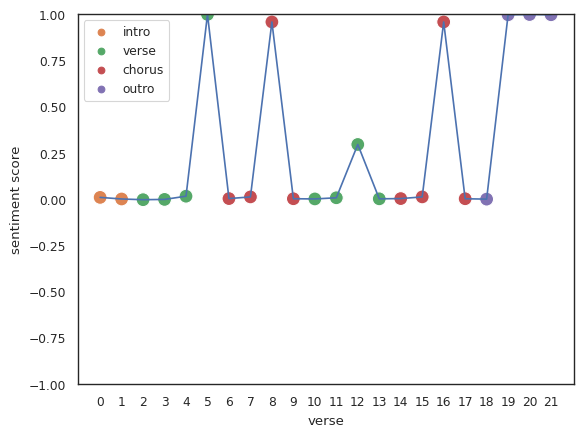

In [16]:
fig, ax = plt.subplots()
ax = plt.plot(eg_sentibert_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_sentibert_ts, 
                     x = range(len(eg_sentibert_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_sentibert_ts)))
ax.set_xlabel('verse')
ax.set_ylabel('sentiment score')
#ax.set_title('Sentiment time series')
ax.set_ylim(-1, 1)
plt.savefig('../pgf/sentibert_ts.pgf', backend='pgf')

In [17]:
# VADER model
sid = SentimentIntensityAnalyzer()

for sentence in sentences:
    print(sentence, sid.polarity_scores(sentence)['compound'])

I love you 0.6369
I hate you -0.5719
I am going to the store to buy some milk. 0.0


In [18]:
def generate_vader_ts(lyrics):
    return [sid.polarity_scores(verse)['compound'] for verse in lyrics]

In [19]:
eg_sentivader_ts = generate_vader_ts(eg_lyrics)

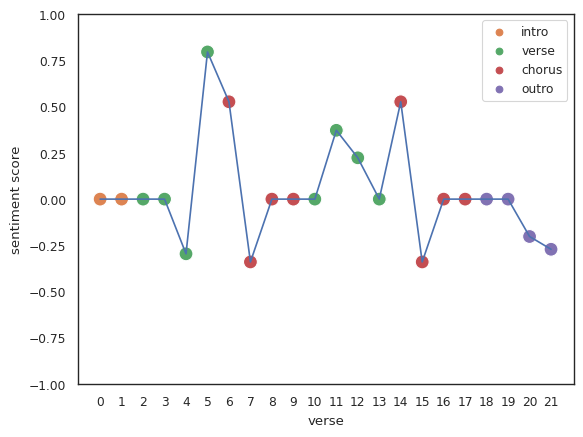

In [20]:
fig, ax = plt.subplots()
ax = plt.plot(eg_sentivader_ts)
# Draw dots representing parts of the lyrics
ax = sns.scatterplot(y = eg_sentivader_ts, 
                     x = range(len(eg_sentivader_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
ax.set_xticks(range(len(eg_sentivader_ts)))
ax.set_xlabel('verse')
ax.set_ylabel('sentiment score')
#ax.set_title('Sentiment time series')
ax.set_ylim(-1, 1)
plt.savefig('../pgf/sentivader_ts.pgf', backend='pgf')

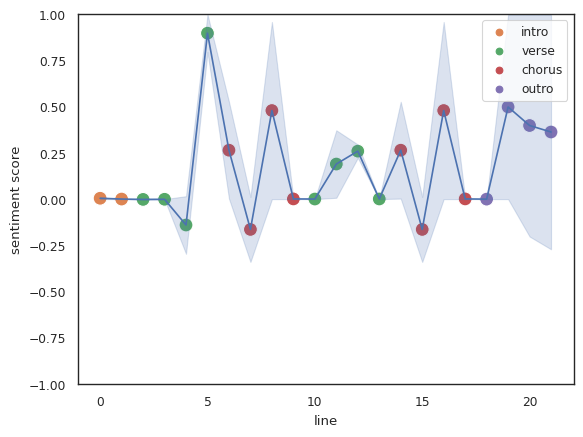

In [21]:
fig, ax = plt.subplots()
# Compute mean for basic scatteplot
eg_sent_ts = np.mean(np.column_stack((eg_sentibert_ts, eg_sentivader_ts)), axis=1)
ax = sns.scatterplot(y = eg_sent_ts, 
                     x = range(len(eg_sent_ts)),
                     hue=parts_of_lyrics, s=100,
                     palette=color_map)
# Create a DataFrame for lineplot
data = {'sentiment': eg_sentibert_ts + eg_sentivader_ts,
        'model': ['bert'] * len(eg_sentibert_ts) + ['vader'] * len(eg_sentivader_ts),
        'timestamp': list(range(0,len(eg_sentibert_ts))) + list(range(0,len(eg_sentivader_ts)))}
eg_sent_ts = pd.DataFrame(data)
ax = sns.lineplot(data=eg_sent_ts, x='timestamp', y='sentiment')
ax.set_xlabel('line')
ax.set_ylabel('sentiment score')
#ax.set_title('Sentiment times series (averaging BERT and VADER)')
ax.set_ylim(-1, 1)
plt.savefig('../pgf/sentiment_ts.pgf', backend='pgf')

In [22]:
"""
ts_data = {'sentivader': {}, 'sentibert': {}, 'sentiment': {}}

sentibert_execution_times = []
sentivader_execution_times = []

for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:        
    # Initialize lists in dict
    for td in ts_data:        
        ts_data[td][lyrics_type] = []    
    for lyr in df[lyrics_type]:
        # Generate sentibert ts for the current ts type
        start_time = time.time()
        sentibert_ts = get_unique_sentiment(sent_pipeline(lyr, top_k=None))
        end_time = time.time()  
        execution_time = end_time - start_time
        sentibert_execution_times.append(execution_time)
        ts_data['sentibert'][lyrics_type].append(sentibert_ts)
        # Generate sentivader ts for the current ts type
        start_time = time.time()
        sentivader_ts = generate_vader_ts(lyr)
        end_time = time.time()
        execution_time = end_time - start_time
        sentivader_execution_times.append(execution_time)
        ts_data['sentivader'][lyrics_type].append(sentivader_ts)
        # Avg the 2 time series for the current ts type
        sentiment_ts = list(np.mean(np.column_stack((
            sentibert_ts, sentivader_ts)), axis=1))                        
        ts_data['sentiment'][lyrics_type].append(sentiment_ts)
        
   
for td in ts_data:
    data = pd.DataFrame(ts_data[td])
    filename = f'../data/evaluation/time-series/{td}_ts.csv'
    data.to_csv(filename, index=False)
"""

"\nts_data = {'sentivader': {}, 'sentibert': {}, 'sentiment': {}}\n\nsentibert_execution_times = []\nsentivader_execution_times = []\n\nfor lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:        \n    # Initialize lists in dict\n    for td in ts_data:        \n        ts_data[td][lyrics_type] = []    \n    for lyr in df[lyrics_type]:\n        # Generate sentibert ts for the current ts type\n        start_time = time.time()\n        sentibert_ts = get_unique_sentiment(sent_pipeline(lyr, top_k=None))\n        end_time = time.time()  \n        execution_time = end_time - start_time\n        sentibert_execution_times.append(execution_time)\n        ts_data['sentibert'][lyrics_type].append(sentibert_ts)\n        # Generate sentivader ts for the current ts type\n        start_time = time.time()\n        sentivader_ts = generate_vader_ts(lyr)\n        end_time = time.time()\n        execution_time = end_time - start_time\n        sentivader_execution_times.append(execution_time)

In [23]:
"""
np.mean(sentibert_execution_times)
"""

'\nnp.mean(sentibert_execution_times)\n'

In [24]:
"""
np.mean(sentivader_execution_times)
"""

'\nnp.mean(sentivader_execution_times)\n'

## Emotion

In [25]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", output_hidden_states = False)

In [26]:
def get_logits(sentence, tokenizer, model, to_numpy=False):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits    
    if to_numpy:
        return logits[0].numpy()
    else:
        return logits

In [27]:
def logits2label(logits, model):
    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]
    return label

In [28]:
lyrics = ["I'm burning with anger, my blood's boiling hot,",
          "Disgusted by your lies, I wish I could rot,",
          "The thought of what's to come, fills me with fear,", 
          "But I won't let it break me, I'll persevere.",
          "Emotions numb, can't feel anything,",
          "For joy awaits me, at the end of the road,",
          "I'll keep moving forward, with a neutral code,",
          "Though sadness lingers, deep in my heart,",
          "Surprise is what I'll feel, when I reach the start."]

In [29]:
logits_tensor = [get_logits(sentence, tokenizer=tokenizer, model=model) for sentence in lyrics]
logits = np.array([lt[0].numpy() for lt in logits_tensor])
labels = [logits2label(lt, model) for lt in logits_tensor]

In [30]:
labels

['anger',
 'disgust',
 'fear',
 'neutral',
 'sadness',
 'joy',
 'neutral',
 'sadness',
 'surprise']

In [31]:
eg_multi_ts = np.array([get_logits(verse, tokenizer=tokenizer, model=model, to_numpy=True) for verse in eg_lyrics])

In [32]:
logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in eg_lyrics]
labels = [logits2label(lt, model=model) for lt in logits_tensor]

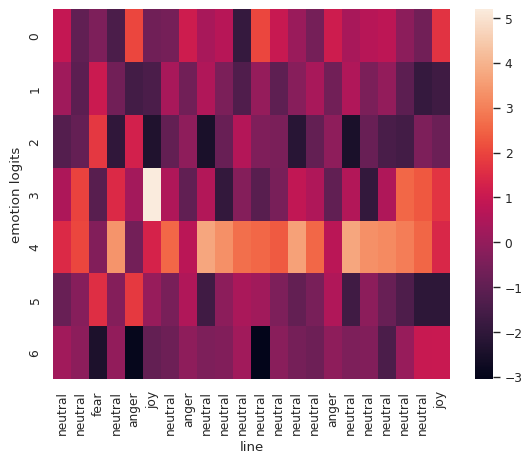

In [33]:
fig, ax = plt.subplots()
ax = sns.heatmap(eg_multi_ts.T)
ax.set_xlabel('line')
ax.set_ylabel('emotion logits')
#ax.set_title('Multivariate time series')
ax.set_xticklabels(labels, rotation=90)
plt.savefig('../pgf/emotion_multi_ts.pgf', backend='pgf')

In [34]:
eg_multi_ts = np.array([get_logits(verse, tokenizer=tokenizer, model=model, to_numpy=True) for verse in lyrics])

In [35]:
logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in lyrics]
labels = [logits2label(lt, model=model) for lt in logits_tensor]

In [36]:
global_scaler = joblib.load('../models/gpca/emo_scaler.pkl')
global_pca = joblib.load('../models/gpca/emo_pca.pkl')

In [37]:
pca_output = global_pca.transform(global_scaler.transform(eg_multi_ts))

eg_uni_ts = np.array(list(
    map(lambda unique_element: unique_element[0], pca_output)))

In [38]:
color_map = {}
for idx, label in enumerate(list(dict.fromkeys(labels))):    
    # Map color excluding first color of the palette 
    color_map[label] = sns.color_palette()[idx+1]

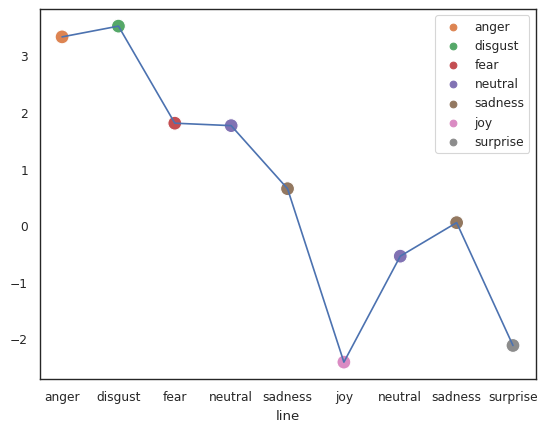

In [39]:
fig, ax = plt.subplots()
ax = plt.plot(eg_uni_ts)
# Draw dots representing parts of the lyrics
ax =  sns.scatterplot(y = eg_uni_ts,
                      x = range(len(eg_uni_ts)),
                      hue=labels, s=100,
                      palette=color_map)
ax.set_xlabel('line')
#ax.set_title('Univariate time series')
ax.set_xticks(range(len(eg_uni_ts)))
ax.set_xticklabels(labels)
#plt.legend(loc='upper left')
plt.savefig('../pgf/emotion_uni_ts_gpca.pgf', backend='pgf')


In [40]:
"""
execution_times = []
ts_data = {}
for lyrics_type in ['lyrics', 'similar_lyrics', 'random_lyrics']:
    ts_data[lyrics_type] = []
    for lyr in df[lyrics_type]:
        start_time = time.time()
        multi_ts = np.array([get_logits(verse, tokenizer=tokenizer, 
                             model=model, to_numpy=True) for verse in lyr])
        end_time = time.time()
        execution_time = end_time - start_time
        execution_times.append(execution_time)
        scl_multi_ts = global_scaler.transform(multi_ts)
        pca_output = global_pca.transform(scl_multi_ts)
        emotion_ts = list(
            map(lambda unique_element: unique_element[0], pca_output))        
        ts_data[lyrics_type].append(emotion_ts)        
ts_data = pd.DataFrame(ts_data)
filename = f'../data/evaluation/time-series/emotion_ts.csv'
ts_data.to_csv(filename, index=False)
"""

In [40]:
"""
np.mean(execution_times)
"""

'\nnp.mean(execution_times)\n'